In [2]:
!pip install qiskit
!pip install pylatexenc

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 46.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 71.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 MB 20.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136816 sha256=c4d0776090c7d9e7050a0049c7a6759b844baf2a89be21af0b354ef92d7cee96
  Stored in directory: /root/.cache/pip/wheels/b1/7a/33/9fdd892f784ed4afda62b685ae3703adf4c91aa0f524c28f03
Successfully built pylatexenc


**Installing dependencies**

In [3]:
from qiskit.visualization import plot_histogram
from qiskit import QuantumCircuit, transpile
from qiskit.providers.basic_provider import BasicSimulator
import numpy as np
from qiskit.quantum_info import DensityMatrix, Statevector
from qiskit.visualization import circuit_drawer, plot_state_city, plot_state_qsphere, plot_bloch_multivector, plot_state_hinton, plot_state_paulivec
from qiskit.visualization import plot_state_qsphere
import matplotlib.pyplot as plt

**Simon Algorithm**

In [4]:
class Simon:
    def __init__(self, secret_string):
        self.secret_string = secret_string
        self.n = len(secret_string)
        self.qc = self.prepare_circuit()
        self.qc1 = self.prepare_circuit1()
        self.simulator = BasicSimulator()
        self.result = None

    def prepare_circuit(self):
        qc = QuantumCircuit(self.n * 2, self.n)
        # Apply Hadamard gates before querying the oracle
        qc.h(range(self.n))
        # Apply barrier for visual separation
        qc.barrier()
        # Append the Simon oracle gate
        oracle_gate = self.simon_oracle(self.secret_string)
        qc.append(oracle_gate, range(self.n * 2))
        # Apply barrier for visual separation
        qc.barrier()
        # Apply Hadamard gates to the input register
        qc.h(range(self.n))
        # Measure qubits
        qc.measure(range(self.n), range(self.n))
        return qc

    def prepare_circuit1(self):
        qc1 = QuantumCircuit(self.n * 2, self.n)
        # Apply Hadamard gates before querying the oracle
        qc1.h(range(self.n))
        # Apply barrier for visual separation
        qc1.barrier()
        # Append the Simon oracle gate
        oracle_gate = self.simon_oracle(self.secret_string)
        qc1.append(oracle_gate, range(self.n * 2))
        # Apply barrier for visual separation
        qc1.barrier()
        # Apply Hadamard gates to the input register
        qc1.h(range(self.n))
        return qc1

    def run_simulation(self, shots=1024):
        transpiled_qc = transpile(self.qc, self.simulator)
        job = self.simulator.run(transpiled_qc, shots=shots)
        self.result = job.result()

    def run_simulation1(self, shots=1024):
        transpiled_qc = transpile(self.qc1, self.simulator)
        job = self.simulator.run(transpiled_qc, shots=shots)
        self.result = job.result()

    def simon_oracle(self, b):
        """returns a Simon oracle for bitstring b"""
        b = b[::-1]  # reverse b for easy iteration
        n = len(b)
        qc = QuantumCircuit(n * 2)
        # Do copy; |x>|0> -> |x>|x>
        for q in range(n):
            qc.cx(q, q + n)
        if '1' not in b:
            return qc.to_gate(label="Oracle")  # 1:1 mapping, so just exit
        i = b.find('1')  # index of first non-zero bit in b
        # Do |x> -> |s.x> on condition that q_i is 1
        for q in range(n):
            if b[q] == '1':
                qc.cx(i, q + n)
        return qc.to_gate(label="Oracle")

    def bdotz(self, b, z):
        accum = 0
        for i in range(len(b)):
            accum += int(b[i]) * int(z[i])
        return (accum % 2)

    def get_counts(self):
        if self.result:
            counts = self.result.get_counts()
            print('secret_string = ' + self.secret_string)
            for z in counts:
                print('{} . {} = {} (mod 2) ({:.1f}%)'.format(
                    self.secret_string, z, self.bdotz(self.secret_string, z), counts[z] * 100 / sum(counts.values())))
            return counts
        else:
            raise RuntimeError("Simulation has not been run yet.")

    def plot_result(self):
        if self.result:
            counts = self.result.get_counts()
            return plot_histogram(counts)
        else:
            raise RuntimeError("Simulation has not been run yet.")

    def psi(self):
        psi = Statevector(self.qc1)
        return psi

    def get_density(self):
        psi = Statevector(self.qc1)
        return DensityMatrix(psi).draw("latex").data

    def get_city(self):
        psi = Statevector(self.qc1)
        return plot_state_city(psi)

    def get_circuit(self):
        return circuit_drawer(self.qc, output='mpl', filename='circuit.png')

    def get_hinton(self):
        psi = Statevector(self.qc1)
        return plot_state_hinton(psi)

    def get_paulivec(self):
        psi = Statevector(self.qc1)
        return plot_state_paulivec(psi)

    def get_qsphere(self):
        psi = Statevector(self.qc1)
        return plot_state_qsphere(psi)

    def get_bloch(self):
        psi = Statevector(self.qc1)
        return plot_bloch_multivector(psi)

**Running simulation with measurement**

In [5]:
secret_string = '11'
simulator = Simon(secret_string)
simulator.run_simulation()

**Counts**

In [6]:
simulator.get_counts()

secret_string = 11
11 . 00 = 0 (mod 2) (49.9%)
11 . 11 = 0 (mod 2) (50.1%)


{'00': 511, '11': 513}

**Running simuation wihout measurements**

In [7]:
simulator.run_simulation1()

**Density matrix**

In [8]:
from IPython.display import display, Latex
dmatrix=simulator.get_density()
display(Latex(dmatrix))

<IPython.core.display.Latex object>

**Qsphere representation**

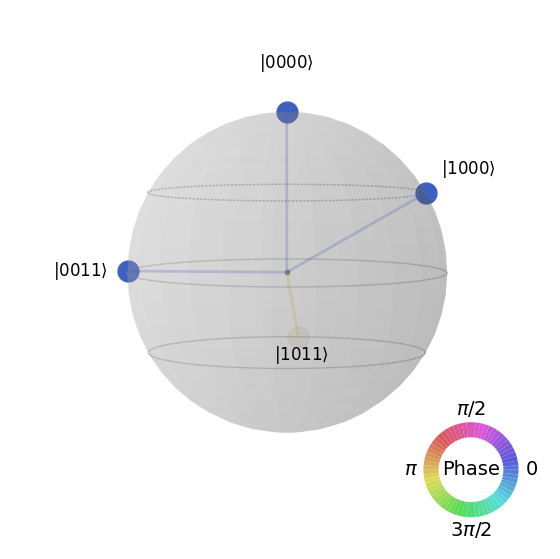

In [9]:
simulator.get_qsphere()

**City Representation**

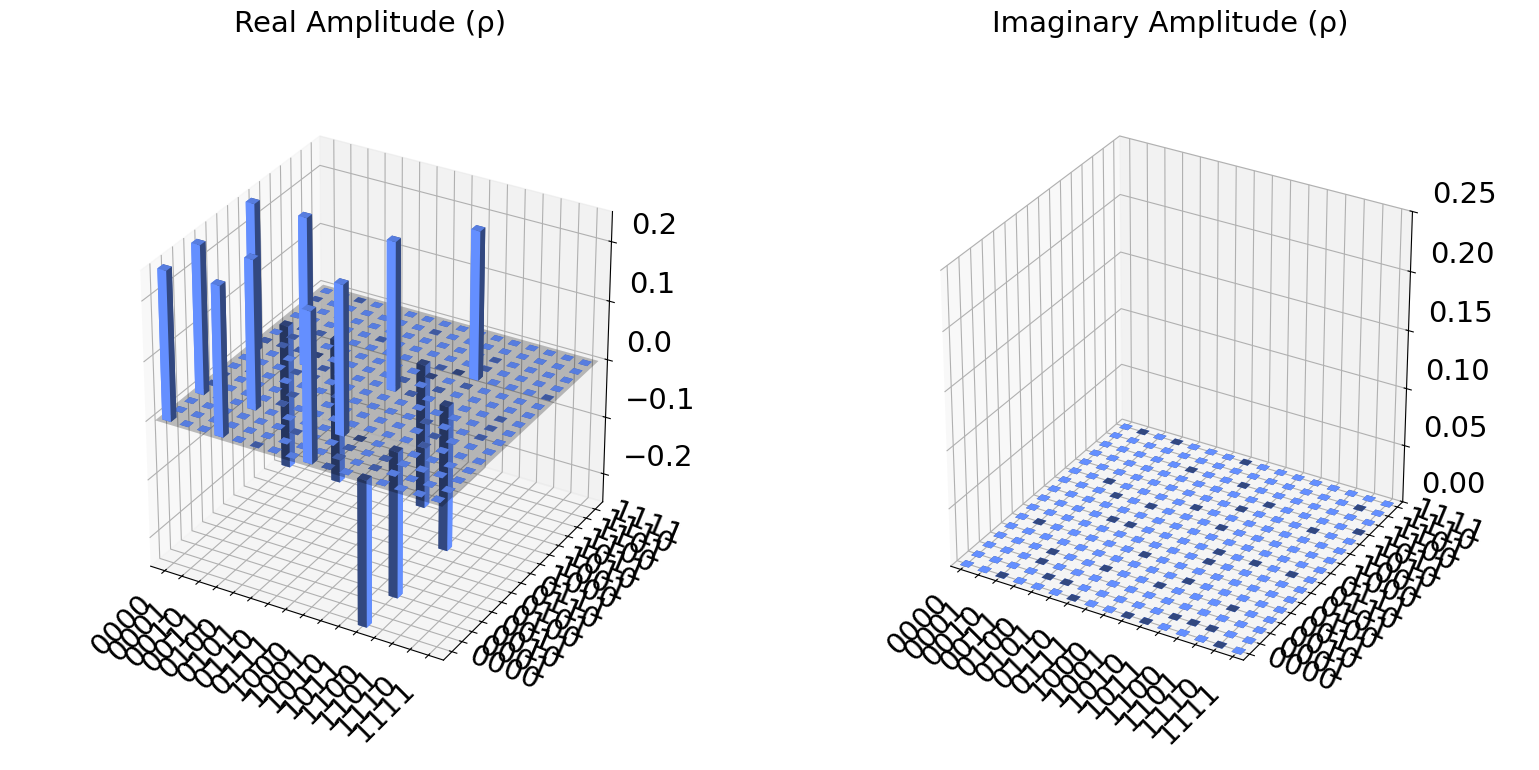

In [10]:
simulator.get_city()

**Circuit Representation**

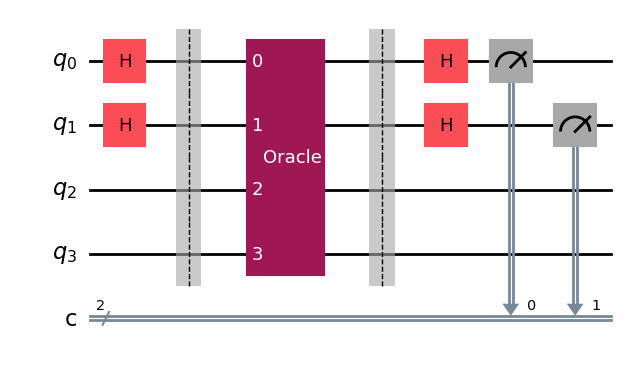

In [11]:
simulator.get_circuit()

**Hinton Representation**

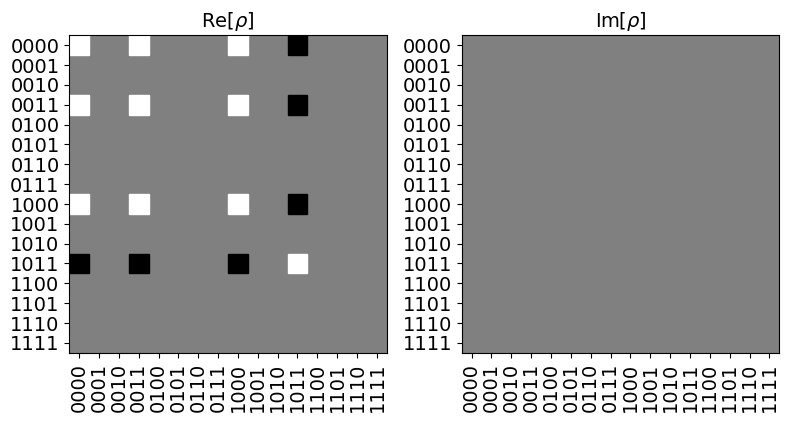

In [12]:
simulator.get_hinton()

**Paulivector Representation**

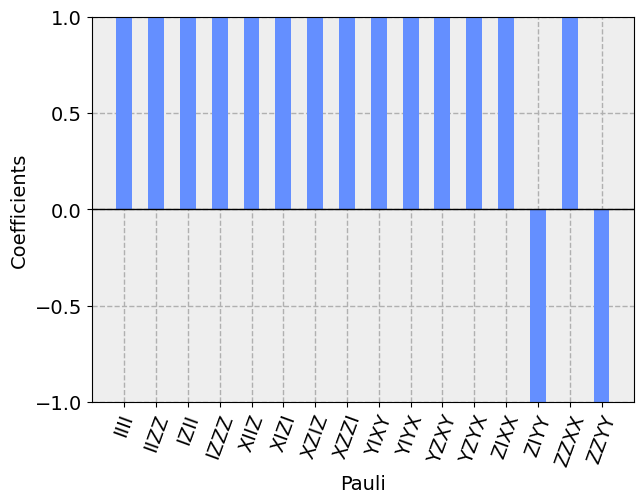

In [13]:
simulator.get_paulivec()

**Bloch sphere Representation**

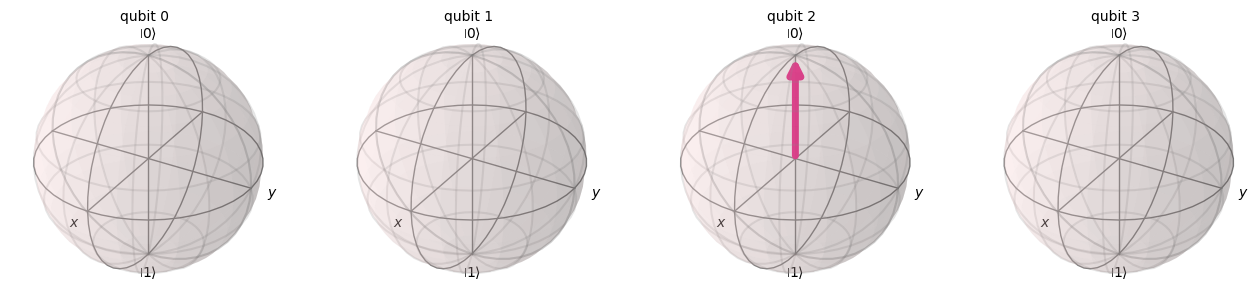

In [14]:
simulator.get_bloch()